# <p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Goal : Predict the price of a house by features
</p>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">Feel free to share your ideas with me.</a></p>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">Outlines : </a></p>
<ul>
    <li><a href="#1.0"><b>1.Imports</b></a>
    <li><a href="#2.0"><b>2.Kaggle  preparing commands</b></a>
    <li><a href="#3.0"><b>3.Functions</b></a>
    <li><a href="#4.0"><b>4.Read and clean train data</b></a>
    <li><a href="#5.0"><b>5.Encode categorical data</b></a>
    <li><a href="#6.0"><b>6.Some info about data and visualizations</b></a>
    <li><a href="#7.0"><b>7.PCA</b></a>
    <li><a href="#8.0"><b>8.Classifiers</b></a>
    <li><a href="#9.0"><b>9.Grid Search</b></a>
    <li><a href="#10.0"><b>10.Load test data</b></a>
        
</ul>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">References : </a></p>

https://stackoverflow.com/questions/43355044/cumulative-explained-variance-for-pca-in-python

https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe

https://stackoverflow.com/questions/23294616/how-to-use-scikit-learn-pca-for-features-reduction-and-know-which-features-are-d

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning

https://www.kaggle.com/khkuggle/simple-and-intermediate-eda-modeling-for-titanic for some visualizations

https://www.kaggle.com/alaasedeeq/object-oriented-programming-for-data-science for outlines and markdown

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/

https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

https://github.com/tpradeep8/tableau-data-visualization/blob/master/titanic%20passenger%20list.csv to create ground truth for testing

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

<a id="1.0"></a>
<h1>1.Imports</h1>

In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy
import time
from math import sqrt
import seaborn as sns

import re
import pickle

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.svm import SVR,SVC
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from rgf.sklearn import RGFClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=Warning)

%matplotlib inline

<a id="2.0"></a>
<h1>2.Kaggle  preparing commands</h1>

In [2]:
# !mkdir data
# !cp /kaggle/input/titanic/train.csv ./data/train.csv
# !cp /kaggle/input/titanic/test.csv ./data/test.csv

<a id="3.0"></a>
<h1>3.Functions</h1>

In [137]:
def execution_time_calculator(start_time):
    delta = time.time() - start_time
    print("--- %s seconds ---" % (delta))
    

# def df_clean(df):
#     df["date"] = df["date"].apply(time_to_standard)
#     df = df.drop_duplicates(subset=['date'])
#     dropped_df = df.dropna(axis=1).dropna().drop(['unix', 'symbol'], axis=1)  



def plot_train_data(df):
    for col in df.columns :
        plt.figure(figsize=(10, 5))
        sns.distplot(df[col])
        plt.title(col)
#     plt.plot(df.index, df['Age'])

#     plt.show()
    return None


def impute_age(cols,age_mean_female,age_mean_male):
    Age = cols[0]
    Sex = cols[1]
    
    if pd.isnull(Age):
        if Sex == "female":
            return age_mean_female
        elif Sex == "male":
            return age_mean_male
    else:
        return Age


def df_clean(df,mode=0,pre_age_values=None):
    if mode==0:
        age_mean_male = df.groupby(['Sex']).mean()["Age"][1]
        age_mean_female = df.groupby(['Sex']).mean()["Age"][0]
        age_mean_list = [age_mean_female,age_mean_male]
#         df.groupby(['Pclass']).mean()["Age"]
    elif mode==1:
        age_mean_male   = pre_age_values[1]
        age_mean_female = pre_age_values[0]
        age_mean_list = pre_age_values
    
    values = {"Cabin": "-", "Embarked": "-","Pclass":0,"Sex":"male","SibSp":0,"Parch":0,"Ticket":"-","Fare":0}
    df['Age'] = df[['Age', 'Sex']].apply(impute_age, args = (age_mean_male,age_mean_female) ,axis=1)
    
    df = df.fillna(value=values)
    df["Family size"] = df['SibSp'] + df['Parch'] + 1 
    # df = df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Survived"]]
    if mode==0:
#         df = df
        df = df[['Pclass', 'Sex', 'Age', "SibSp", "Parch", "Fare", "Embarked", "Cabin", "Family size", "Survived"]]
    elif mode==1:
        df = df[['Pclass', 'Sex', 'Age', "SibSp", "Parch", "Fare", "Embarked", "Cabin", "Family size",]]

    return df,age_mean_list


def column_onehot_encoder(df,column,encoder,fit=0):
    if fit==0:
        encoder.fit(df[column].values.reshape(-1,1))
    feature_names = encoder.get_feature_names([column])
    data = encoder.transform(df[column].values.reshape(-1,1))
    df_one_hot = pd.DataFrame(data, columns = feature_names).astype('int64')

    return encoder, df_one_hot


def df_one_column_encoder(df,column,index,mode,encoder_mode,E_list):
    if mode==0:
        if encoder_mode=="L":
            E_col = LabelEncoder()
        elif encoder_mode=="O":
            E_col = OneHotEncoder(sparse=False,drop="first")
    elif mode==1:
        E_col = E_list[index]
        
    if encoder_mode=="L": 
        df[column] = E_col.fit_transform(df[column])
        
    elif encoder_mode=="O":
        E_col, df_column = column_onehot_encoder(df,column,E_col,fit=mode)
        df = df.drop(columns=[column])
        df = pd.concat([df, df_column],axis=1)

    return df,E_col


def df_encoder(df,columns,mode=0,encoder_mode="L",E_list=None):
    encoders_list = []
#     feature_names_list = []
    for index in range(len(columns)):
        df,E_col = df_one_column_encoder(df,columns[index],index,mode,encoder_mode,E_list)
        encoders_list.append(E_col)
#         feature_names_list.append(feature_names)
        
    
    return df, encoders_list




def metrics_calculator(real,pred,mode):
    print("********",mode,"********",":")
    metrics_lists=[metrics.accuracy_score,metrics.f1_score,metrics.precision_score,metrics.recall_score,metrics.average_precision_score,metrics.roc_auc_score,metrics.mean_squared_error,metrics.mean_squared_error]
    metric_names=["Accuracy","F1","Precision","Recall","AP","RoC_AuC","MSE"]
    for metric in range(len(metrics_lists)):
        if metric== len(metrics_lists)-1:
            metric_value = metrics_lists[metric](real, pred)
            print("{:20}".format("{}: ".format("RMSE")),sqrt(metric_value))
        else:  
            metric_value = metrics_lists[metric](real, pred)
            print("{:20}".format("{}: ".format(metric_names[metric])),metric_value)
        
#     report = classification_report(real, pred)
#     print(report)


    
def all_models_test(df,models,models_name,x_train,y_train):

    classifiers = []
    for i in range(len(models)):
        print("--------",models_name[i],"--------")
        clf = models[i].fit(x_train, y_train)
        y_pred_train = clf.predict(x_train)
        metrics_calculator(y_pred_train,y_train,"train")
        classifiers.append(clf)
    return classifiers

<a id="4.0"></a>
<h1>4.Read and clean train data</h1>

In [11]:
df = pd.read_csv("./data/train.csv")

In [12]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [138]:
df_cleaned,age_mean_list = df_clean(df)

In [98]:
df_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,Family size,Survived
0,3,male,22.0,1,0,7.2500,S,-,2,0
1,1,female,38.0,1,0,71.2833,C,C85,2,1
2,3,female,26.0,0,0,7.9250,S,-,1,1
3,1,female,35.0,1,0,53.1000,S,C123,2,1
4,3,male,35.0,0,0,8.0500,S,-,1,0


<a id="5.0"></a>
<h1>5.Encode categorical data</h1>

In [99]:
# df_cleaned.columns
# X

In [100]:
global_encoding_mode = "L"
df_encoded, encoders_list = df_encoder(df_cleaned,["Sex","Embarked","Cabin"],mode=0,encoder_mode=global_encoding_mode)

# pandas encoding - not good when we want to apply on test data

# first way
# df['Sex'] = df['Sex'].astype('category')
# df['Cabin'] = df['Cabin'].astype('category')
# df['Embarked'] = df['Embarked'].astype('category')
# OneHotEncoder().fit_transform(df)
# cat_columns = df.select_dtypes(['category']).columns
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)


# second way
# X = pd.get_dummies(df_cleaned[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','Survived']])
# X_test = pd.get_dummies(test_data[features])

In [101]:
df_encoded.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,Family size,Survived
0,3,1,22.0,1,0,7.2500,3,0,2,0
1,1,0,38.0,1,0,71.2833,1,82,2,1
2,3,0,26.0,0,0,7.9250,3,0,1,1
3,1,0,35.0,1,0,53.1000,3,56,2,1
4,3,1,35.0,0,0,8.0500,3,0,1,0


In [102]:
array = df_encoded.values
X = array[:,:-1]
Y = array[:,-1]

<a id="6.0"></a>
<h1>6.Some info about data and visualizations</h1>

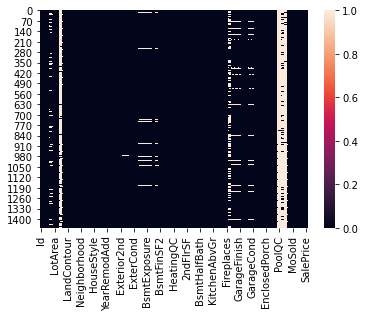

In [16]:
# plot na fields
sns.heatmap(df.isna());

In [104]:
df_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Sex          891 non-null    int32  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked     891 non-null    int32  
 7   Cabin        891 non-null    int32  
 8   Family size  891 non-null    int64  
 9   Survived     891 non-null    int64  
dtypes: float64(2), int32(3), int64(5)
memory usage: 59.3 KB


In [105]:
# print(df_cleaned["Cabin"].unique())
# print(df_cleaned["Cabin"].describe())
# print(df_cleaned.describe())
# print(df_cleaned["Cabin"].value_counts())
# print(df_cleaned['Embarked'].value_counts().idxmax())
# sns.countplot(x='Embarked',data=df_clean,palette='Set2')

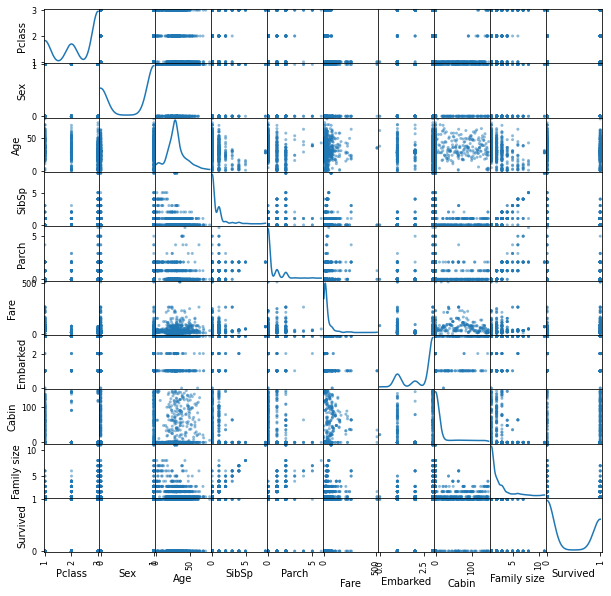

In [106]:
pd.plotting.scatter_matrix(df_encoded, diagonal='kde', figsize=(10, 10));

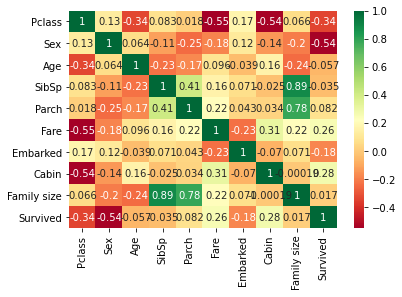

In [107]:
sns.heatmap(df_encoded.corr(),annot=True,cmap="RdYlGn");

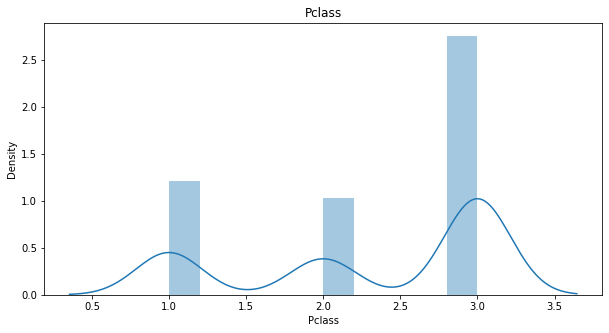

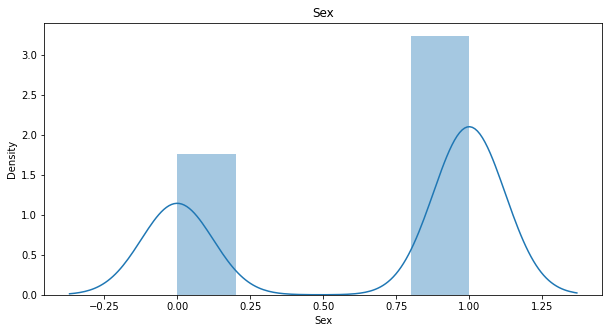

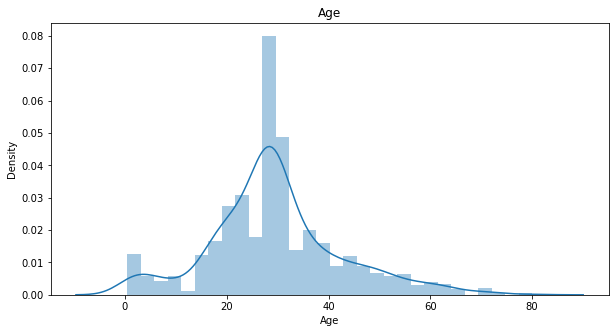

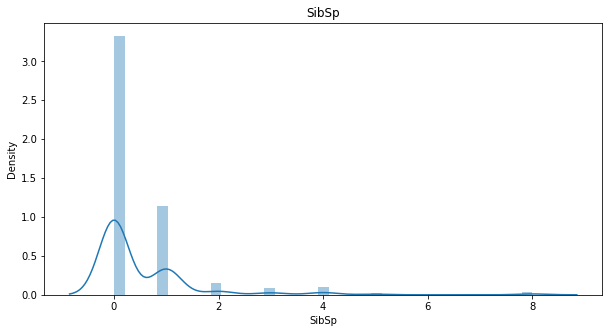

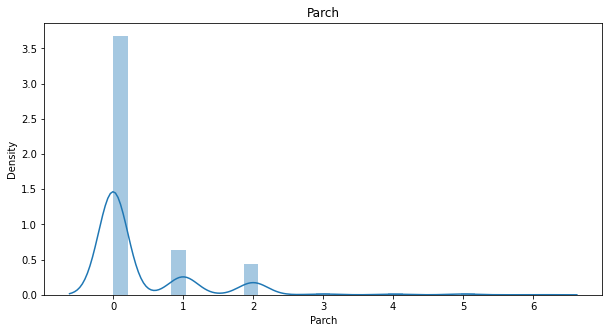

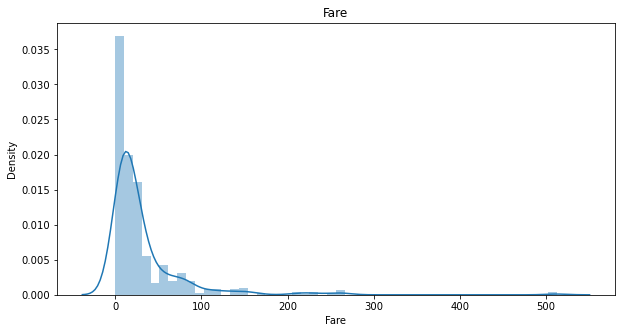

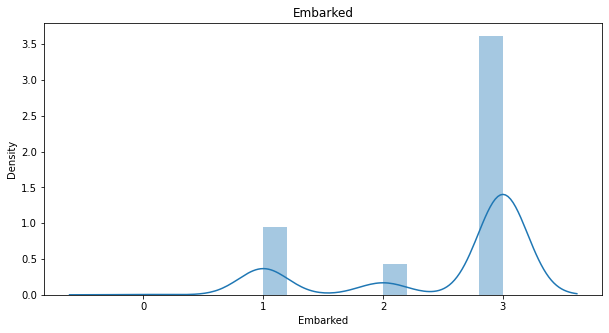

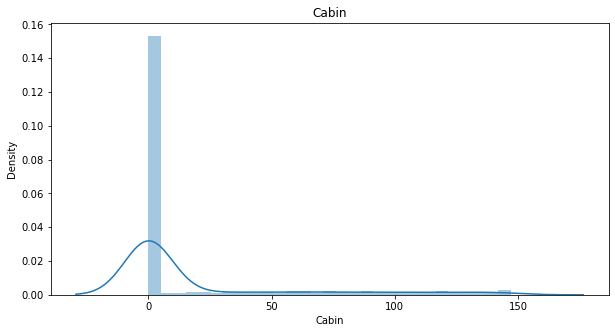

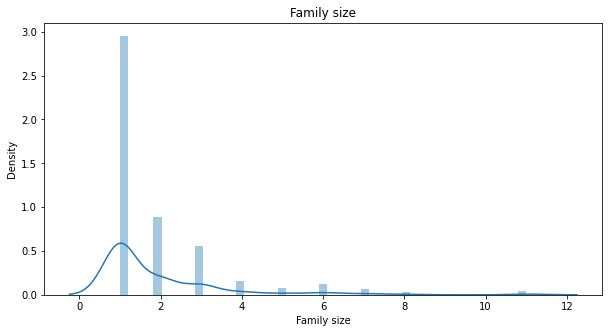

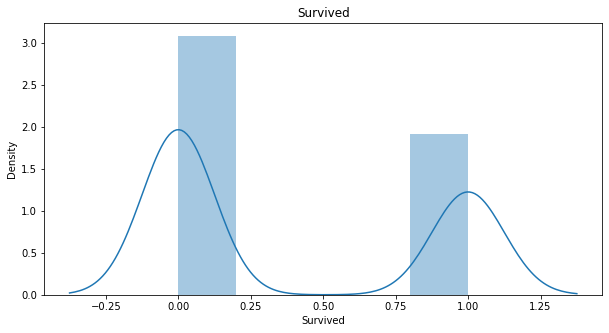

In [108]:
plot_train_data(df_encoded);

In [109]:
df_encoded.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin',
       'Family size', 'Survived'],
      dtype='object')

<AxesSubplot:xlabel='Survived', ylabel='count'>

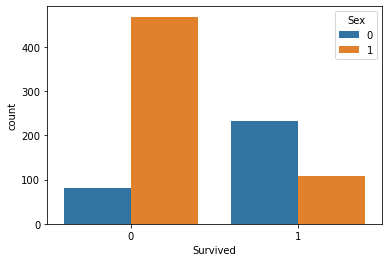

In [110]:
sns.countplot(x = 'Survived', hue='Sex', data=df_encoded)

In [111]:
# sns.countplot(x = 'Survived', hue='Age', data=df_encoded)

<AxesSubplot:xlabel='Survived', ylabel='count'>

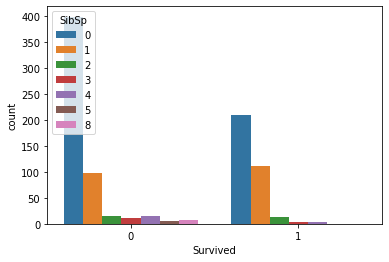

In [112]:
sns.countplot(x = 'Survived', hue='SibSp', data=df_encoded)

In [113]:
# sns.countplot(x = 'Survived', hue='Fare', data=df_encoded)

In [114]:
# sns.countplot(x = 'Survived', hue='Cabin', data=df_encoded)

<AxesSubplot:xlabel='Survived', ylabel='count'>

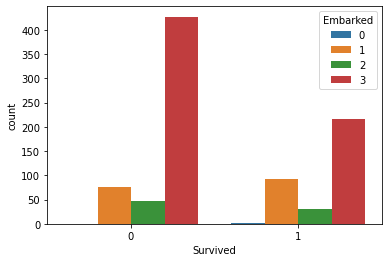

In [115]:
sns.countplot(x = 'Survived', hue='Embarked', data=df_encoded)

<AxesSubplot:xlabel='Survived', ylabel='count'>

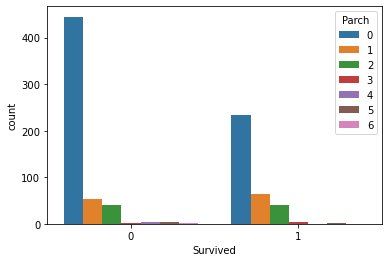

In [116]:
sns.countplot(x = 'Survived', hue='Parch', data=df_encoded)

<AxesSubplot:xlabel='Survived', ylabel='count'>

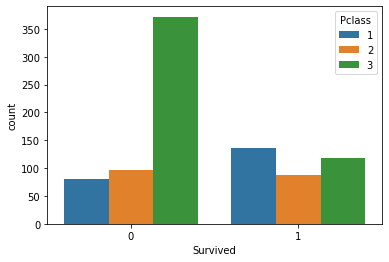

In [117]:
sns.countplot(x = 'Survived', hue='Pclass', data=df_encoded)

<AxesSubplot:xlabel='Survived', ylabel='count'>

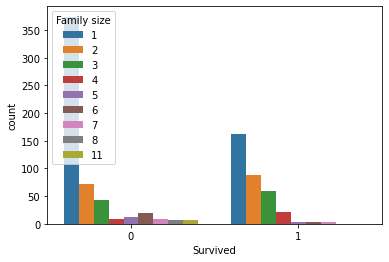

In [118]:
sns.countplot(x = 'Survived', hue="Family size", data=df_encoded)

<a id="7.0"></a>
<h1>7.PCA</h1>

In [119]:
pca = PCA(n_components=2)
fit = pca.fit(X)
# summarize components
explained_variance_ratio=fit.explained_variance_ratio_

print(explained_variance_ratio)
print(len(explained_variance_ratio))
print(sum(explained_variance_ratio))
x_pca_train = pca.transform(X)

y_train = Y
x_train = X

[0.66917694 0.28945607]
2
0.9586330102863256


<a id="8.0"></a>
<h1>8.Classifiers</h1>

In [120]:
def all_classifiers_generator(mode=0):
    if mode==0:
        BNB = BernoulliNB()
        GNB = GaussianNB()
        RF = RandomForestClassifier()
        DTree = DecisionTreeClassifier()
        KNN = KNeighborsClassifier()
        LR = LogisticRegression()
        MLP = make_pipeline(MinMaxScaler(), MLPClassifier(random_state=0, shuffle=False))
        XGB = xgb.XGBClassifier(eval_metric='mlogloss')
        SVC_auto = make_pipeline(MinMaxScaler(), SVC(gamma="auto"))
        RGF = RGFClassifier()
        Bagging = BaggingClassifier(random_state=0)
        custom_RF=RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=6, min_samples_leaf=6, warm_start=True)
        AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=0)

    elif mode==1:
        BNB = make_pipeline(MinMaxScaler(), BernoulliNB())
        GNB = make_pipeline(MinMaxScaler(), GaussianNB())
        RF = make_pipeline(MinMaxScaler(), RandomForestClassifier())
        DTree = make_pipeline(MinMaxScaler(), DecisionTreeClassifier())
        KNN = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
        LR = make_pipeline(MinMaxScaler(), LogisticRegression())
        MLP = make_pipeline(MinMaxScaler(), MLPClassifier(random_state=0, shuffle=False))
        XGB = make_pipeline(MinMaxScaler(), xgb.XGBClassifier(eval_metric='mlogloss'))
        SVC_auto = make_pipeline(MinMaxScaler(), SVC(gamma="auto"))
        RGF = make_pipeline(MinMaxScaler(), RGFClassifier())
        Bagging = make_pipeline(MinMaxScaler(), BaggingClassifier(random_state=0))
        custom_RF=make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=6, min_samples_leaf=6, warm_start=True))
        AdaBoost = make_pipeline(MinMaxScaler(),AdaBoostClassifier(n_estimators=100, random_state=0))

    estimators = [
       ('xgb', xgb.XGBClassifier(eval_metric='mlogloss')),
       ('lr', LogisticRegression()),
       ('nb', BernoulliNB()),
       ('rgf', RGFClassifier()),
       ('svm', make_pipeline(StandardScaler(), SVC(gamma="auto"))),
       ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=0, shuffle=False))),
    ]
    Voting = VotingClassifier(estimators)
    Stacking = StackingClassifier(copy.deepcopy(estimators), LogisticRegression())

    models = [BNB,GNB,RF,custom_RF,DTree,KNN,LR,MLP,XGB,SVC_auto,RGF,Bagging,AdaBoost,Voting,Stacking]
    models_name = ["BNB","GNB","RF","custom_RF","DTree","KNN","LR","MLP","XGB","SVC_auto","RGF","Bagging","AdaBoost","Voting","Stacking"]
    
    return models, models_name

In [121]:
models, models_name = all_classifiers_generator(mode=1)

In [122]:
start_time = time.time()

classifiers = all_models_test(df_encoded,models[:],models_name,x_train,y_train)

execution_time_calculator(start_time)

-------- BNB --------
******** train ******** :
Accuracy:            0.7362514029180696
F1:                  0.6497764530551416
Precision:           0.6374269005847953
Recall:              0.662613981762918
AP:                  0.5469471012584115
RoC_AuC:             0.7209867061839501
MSE:                 0.26374859708193044
RMSE:                0.5135645987428752
-------- GNB --------
******** train ******** :
Accuracy:            0.7912457912457912
F1:                  0.7372881355932204
Precision:           0.7631578947368421
Recall:              0.7131147540983607
AP:                  0.6620642722886037
RoC_AuC:             0.7794145199063232
MSE:                 0.20875420875420875
RMSE:                0.4568962778948946
-------- RF --------
******** train ******** :
Accuracy:            0.9865319865319865
F1:                  0.9823529411764705
Precision:           0.9766081871345029
Recall:              0.9881656804733728
AP:                  0.9695400316183043
RoC_AuC:        

<a id="9.0"></a>
<h1>9.Grid Search</h1>

In [123]:
def grid_search(param_grid,model,X_train,Y_train):
    
    clf = GridSearchCV(model, param_grid, verbose=3)
    clf.fit(X_train,Y_train)
#     sorted(clf.cv_results_.keys())

    y_pred_train = clf.predict(X_train)
    metrics_calculator(y_pred_train,Y,"train")
    return clf

In [124]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# grid_rf = grid_search(param_grid,models[2],X,Y)

In [125]:
param_grid = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

# grid_knn = grid_search(param_grid,KNeighborsClassifier(),X,Y)

In [126]:
param_grid = {
#     "base_estimator" : ["gini", "entropy"],
#     "algorithm" :   ['SAMME', 'SAMME.R'],
    'n_estimators': [100, 200, 300, 1000]
}

# grid_ada = grid_search(param_grid,AdaBoostClassifier(),X,Y)

<a id="10.0"></a>
<h1>10.Load test data</h1>

In [127]:
# df_labels = pd.read_csv("./data/Titanic.csv")

In [128]:
# df_labels.head()

In [129]:
def create_synced_srvived_col(df_test,df_labels):
    v_test = df_test.values
    v_labels = df_labels.values
    labels_col = []
    for i in range(len(v_test)):
        for j in range(len(v_labels)):
#             print(v_test[i][2],"-------",v_labels[j][0])

            test_string  = re.sub(r"\([^()]*\)", "", v_test[i][2])
            label_string = re.sub(r"\([^()]*\)", "", v_labels[j][0])
        
            test_string = re.sub(r"[\s\.]", "", test_string)
            label_string = re.sub(r"[\s\.]", "", label_string)

            
            if (test_string==label_string):# and (v_test[i][4]==v_labels[j][2]):
#                 print(j)
                labels_col.append(j)
                break

    return labels_col

In [130]:
# labels_col = create_synced_srvived_col(df_test,df_labels)
# len(labels_col)

# v_labels = df_labels.values
# df_labels["ticket"].describe()
# df_labels
# list(np.where(v_labels == "Allen, Miss. Elisabeth Walton"))

# df_test['Name'].where(df_labels['name'] == df_test['Name'])
# result = pd.concat([df_test, df_labels['survived']], axis=1).reindex(df_test.Name)
# pd.concat([df_test, df_labels], axis=1)
# pd.concat([df_test, df_labels], join_axes=[df_test.Name])

In [131]:
df_test = pd.read_csv("./data/test.csv")
ids_col = df_test["PassengerId"].values

In [132]:
# df_test.info()
# df_test

In [139]:
df_test,_ = df_clean(df_test,1,age_mean_list)
df_test,_ = df_encoder(df_test,["Sex","Embarked","Cabin"],mode=1,encoder_mode=global_encoding_mode,E_list=encoders_list)

array_test = df_test.values
x_test = array_test[:,]

In [141]:
def predict_one_classifier(classifier,x_test,labels_col=None):
    y_pred_test = classifier.predict(x_test)
    if labels_col!=None:
        metrics_calculator(labels_col,y_pred_test,"test")
    return y_pred_test

def predic_with_all_classifiers(classifiers,x_test,labels_col=None):
    for i in range(len(classifiers)):
        predict_one_classifier(classifiers[i],x_test)

In [142]:
# predic_with_all_classifiers(classifiers,x_test)
y_pred_test = predict_one_classifier(classifiers[3],x_test)

# y_pred_test = grid_ada.predict(x_test)

In [143]:
df_result = pd.DataFrame(list(zip(list(ids_col),list(y_pred_test))), columns =['PassengerId','Survived'])
df_result['Survived'] = df_result['Survived'].astype('int64')

In [144]:
# df_result

In [145]:
# compression_opts = dict(method='zip',archive_name='out.csv')  

df_result.to_csv('out.csv', index=False)  